In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile

%matplotlib inline
mpl.rcParams['figure.dpi'] = 400

In [2]:
df = pd.read_excel('../Data/df_clean_2.xlsx')

In [3]:
df.columns.to_list()

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT']

For ethical reasons, gender will not be used.

Further, as per our earlier data exploration, PAY_2 through PAY_6 contain faulty data and should also be ignored.

In [4]:
features_response = df.columns.tolist()

In [5]:
features_response

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT']

In [6]:
features_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT']

In [7]:
features = [col for col in features_response if col not in features_to_remove]

C:\Users\clgme\AppData\Local\Temp\ipykernel_23128\1740957252.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0)


<AxesSubplot:>

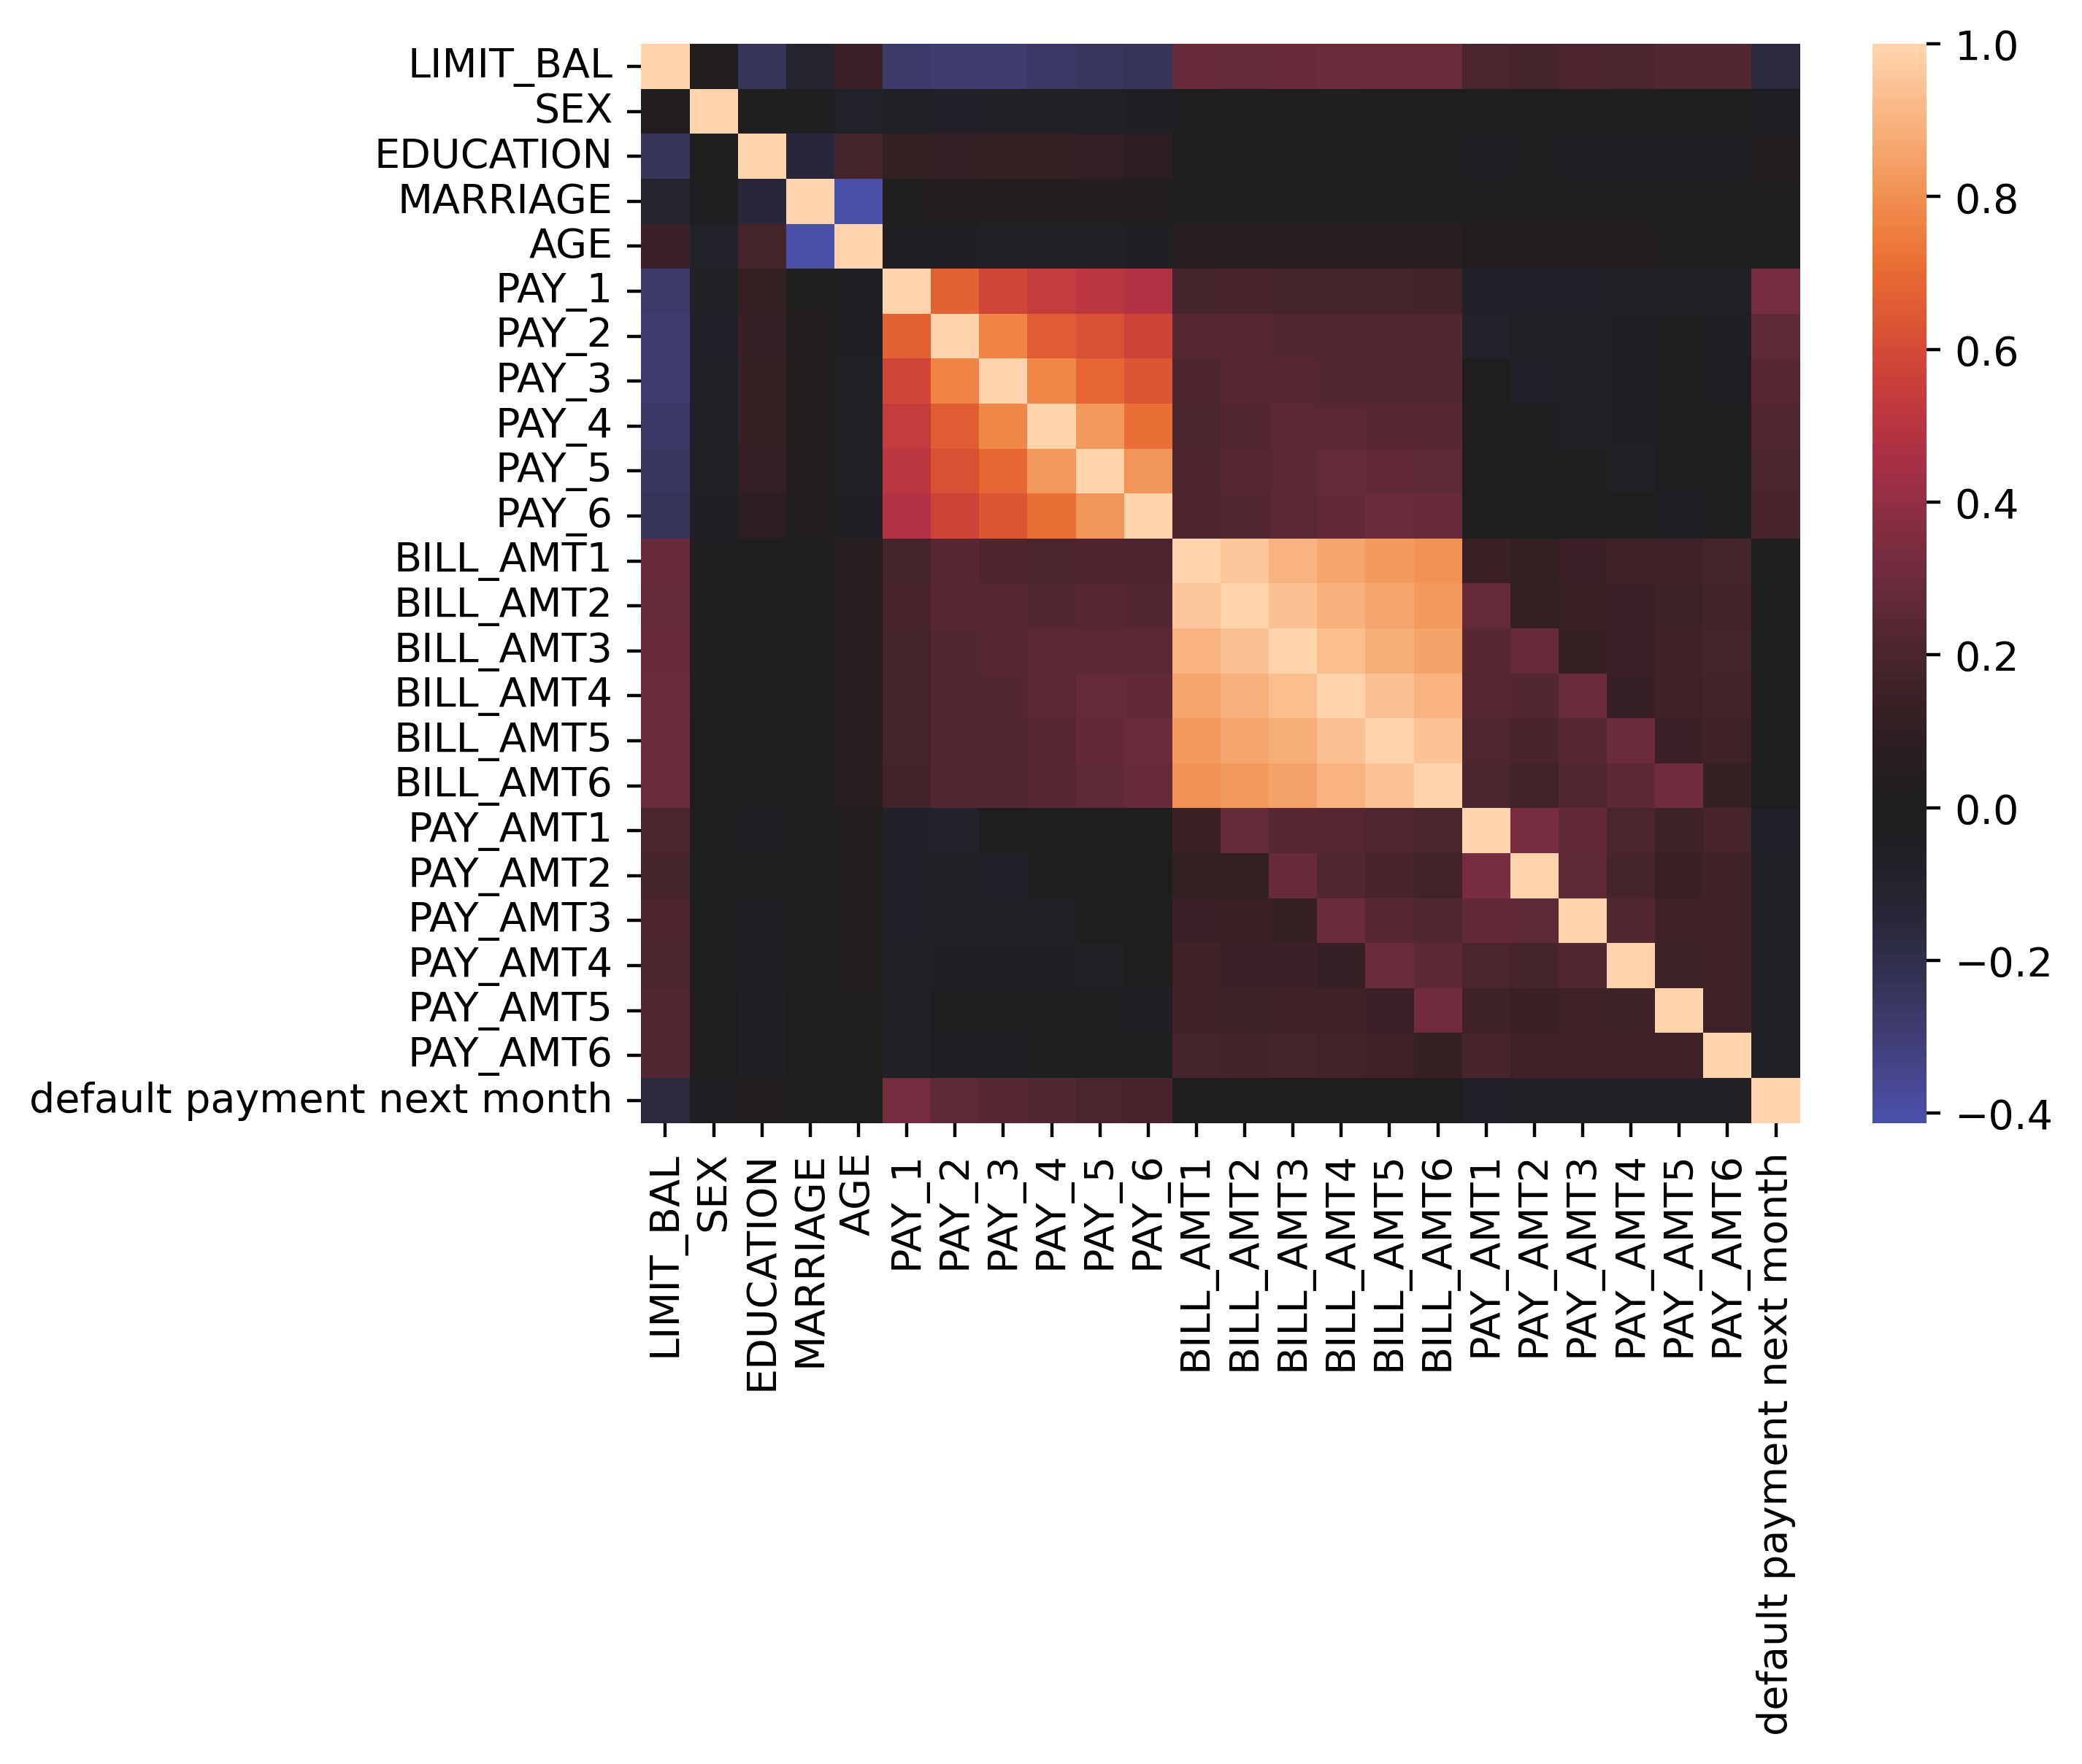

In [8]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0)
# From heatmap, PAY_1 and LIMIT_BAL are the two features with the strongest correlation with response variable default payment next month
# PAY_1 has relatively strong positive correlation with default, whereas LIMIT_BAL has relatively strong negative correlation with default
# PAY_2 - 6 have weak, but still positive correlation with default status

In [9]:
# Pearson correlation above is not 100% approriate for this case study
# This is because data here is binary classification, whereas pearson correlation works best for continuous variables, or regresion
# the usefulness of the above is that it is easy to interpret and glean surface level analysis / information from
# Pearson correlation also only assesses linear relations, which some of the features may or may not have with the response variable

# General examining of feature strength and relation to default payment next month

- F-statistic and p-values

In [10]:
# Because this case study deals with binary classification, can look to use F-statistic / p-values to perform surface level analysis.
# Provides idea of which features would be more important for modeling
X = df[features].iloc[:, :-1]
y = df[features].iloc[:, -1]

In [11]:
[f_stat, f_p_value] = f_classif(X, y)

In [12]:
f_test_df = pd.DataFrame(
    {
        'Feature': features[:-1],
        'F-statistic': f_stat,
        'p value': f_p_value
    }
)

In [13]:
f_test_df.sort_values(by='p value')
# ANOVA F-Test with corresponding p-values is employed here for ranking of feature purposes
# Higher F-statistic and lower p-value indicates that there is a significant difference in the means of the two binary classes for that given feature.
# DataFrame ranking indicates that PAY_1 and LIMIT_BAL are the two features with the greatest significance on the response variable default

# Technically, since this is a binary classification, this would just be a t-test. 
# Further, t-test and F-test assume that the data is normally distributed, which has not been explored yet.
# Additionally, in cases of multi-classification, p-values need to be shifted
# However, for the purpose of ranking the features based on p-value and not performing finalized statistical inferences, this should provide useful surface level analysis

,Feature,F-statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


In [14]:
# To confirm the DataFrame above, use sklearn SelectPercentile to determine the top 20% features
selector = SelectPercentile(f_classif, percentile=20)
selector.fit(X, y)

SelectPercentile(percentile=20)

In [15]:
selector.get_support()

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [16]:
best_features = X.columns[selector.get_support()]
best_features

Index(['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2'], dtype='object')

# Visualizing Relationship Between Features & Response Variable

First, exploring PAY_1 feature. How do the default rates change based on the value of this encoded feature?

Because feature is encoded, creating a plot of default rate for each unique coded value in PAY_1 relative to an average would help visualize any trends

In [19]:
# Plotting default rates of the different 
overall_default_rate = df['default payment next month'].mean()
group_by_pay_mean_y = df.groupby(by='PAY_1').agg({'default payment next month': np.mean})

In [20]:
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


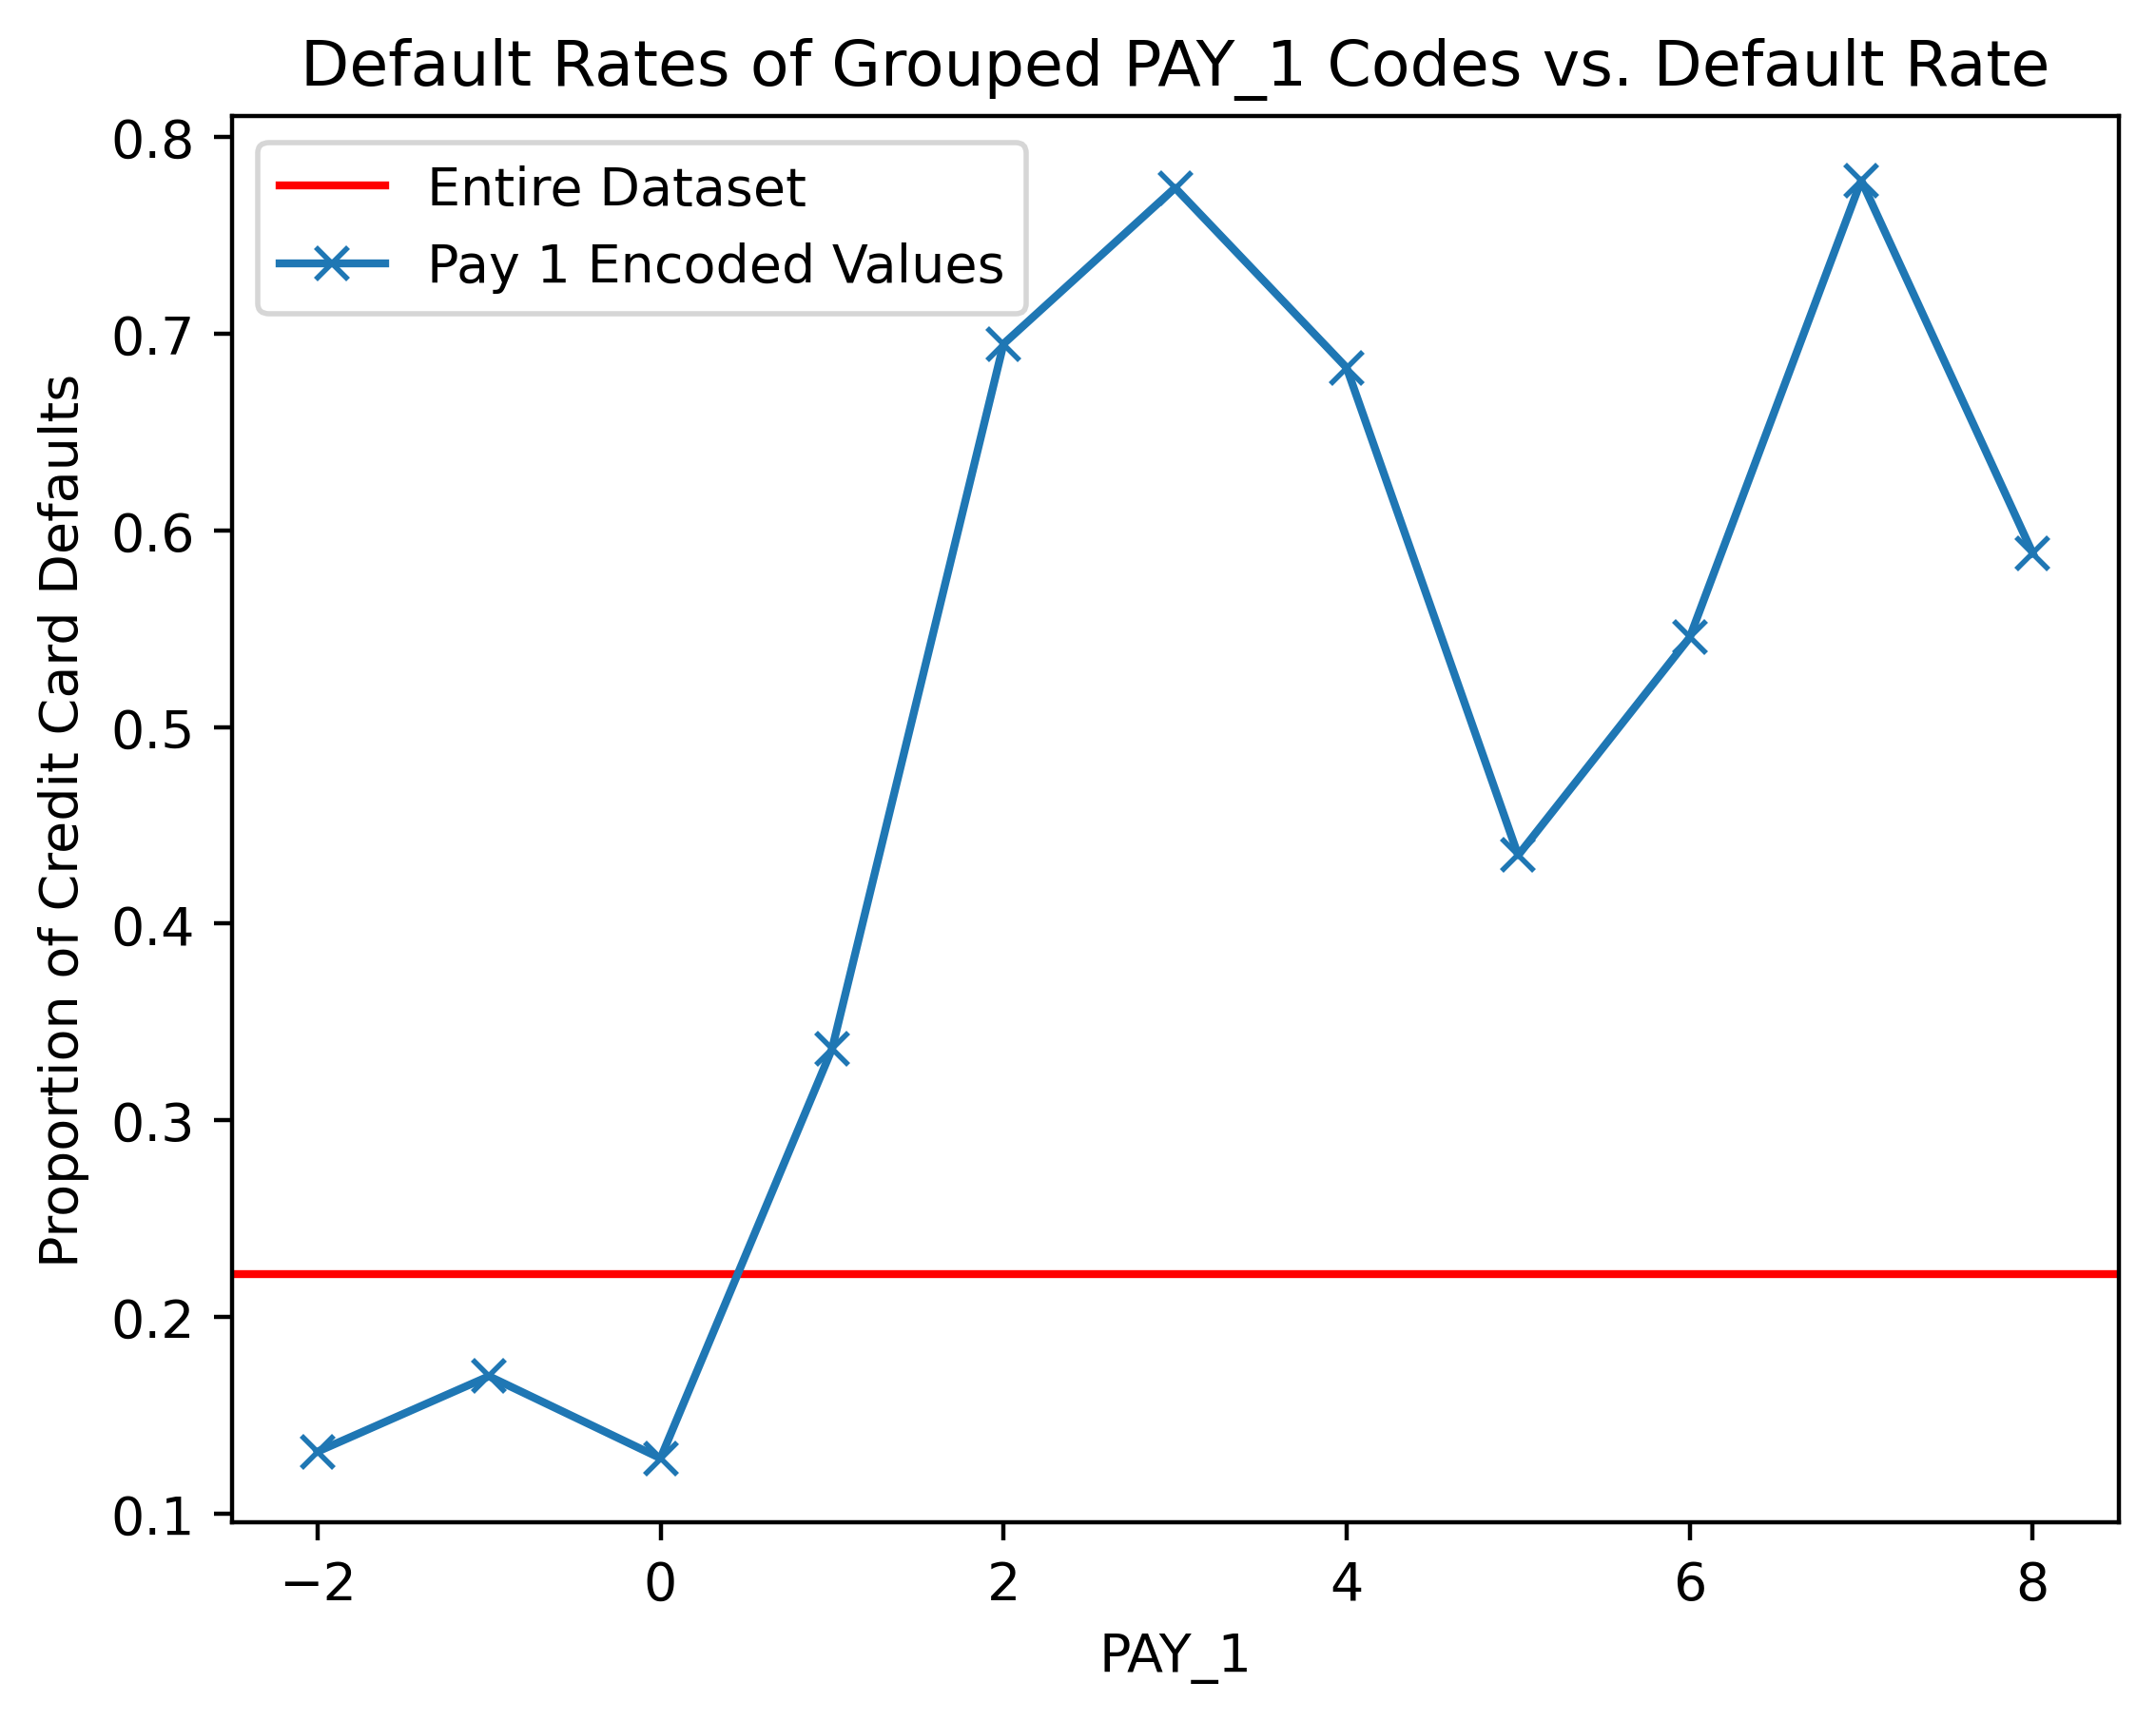

In [24]:
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of Credit Card Defaults')
axes.set_title('Default Rates of Grouped PAY_1 Codes vs. Default Rate')
axes.legend(['Entire Dataset', 'Pay 1 Encoded Values'])

# From visual, it is apparent that default rates tend to climb as delinquency in payment increases. Accounts that have at least paid the monthly minimum or have paid their monthly fees duly exhibit lower default rates.
# Compared to the average default rate of the entire dataset, accounts in good standing are lower than the average default rate of the entire dataset, whereas accounts with delinquent payment statuses exhibit higher than average default rates. This means accounts that are default in this month are more likely to be in default in the next month

Exploring Limit Balance Relation to Default Rate

In this case, limit balance is a continuous variable and is not encoded like PAY_1. To visualize continuous variable values in relation to default statis (encoded response variable), can plot layered histograms to compare values between binary classes

Text(0.5, 1.0, 'Credit Limits vs Defaults')

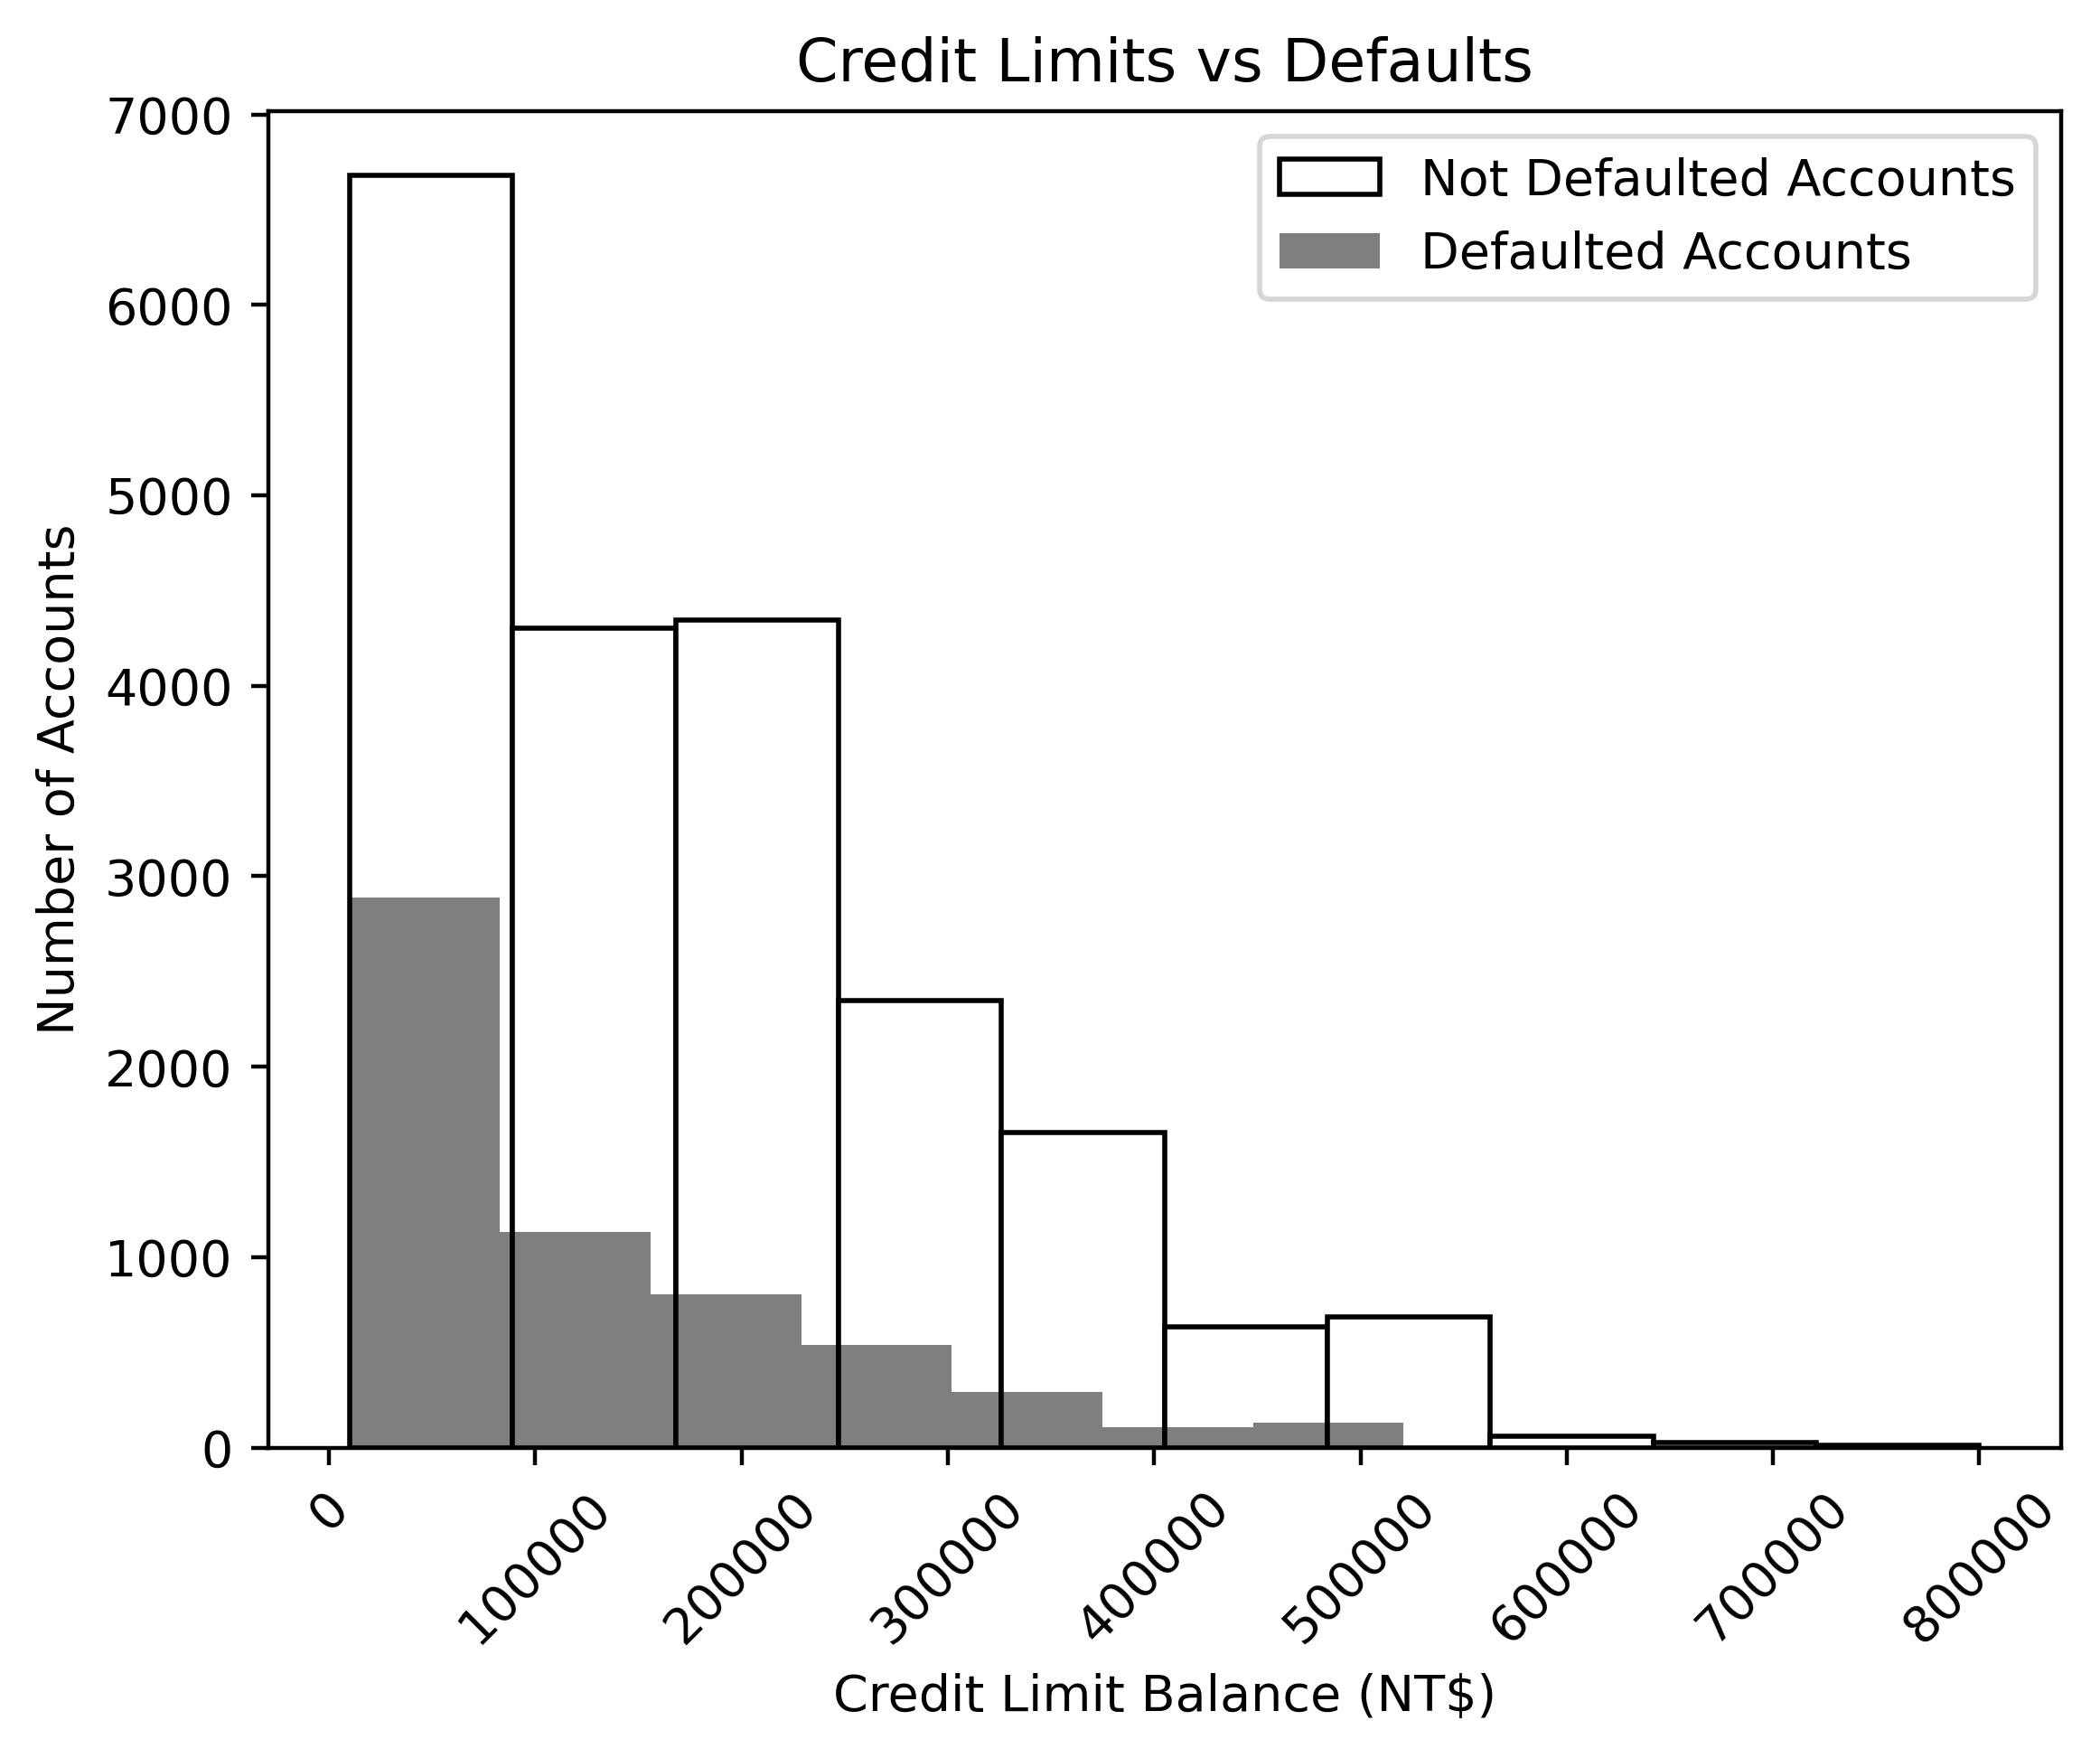

In [26]:
pos_mask = y == 1
neg_mask = y == 0

axes = plt.axes()
axes.hist(x=df.loc[neg_mask, 'LIMIT_BAL'], color='white', edgecolor='black')
axes.hist(x=df.loc[pos_mask, 'LIMIT_BAL'], alpha=0.5, color='black', edgecolor=None)
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit Limit Balance (NT$)')
axes.set_ylabel('Number of Accounts')
axes.legend(['Not Defaulted Accounts', 'Defaulted Accounts'])
axes.set_title('Credit Limits vs Defaults')